In [3]:
from vectorgeo.raster import RasterPatches
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [4]:


dem_raster_path = "tmp/gmted-full.tif"
lc_raster_path  = "tmp/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"

gdf = gpd.read_file('tmp/world.gpkg')

patch_size = 64
dem_extractor = RasterPatches(dem_raster_path, gdf, 64, full_load=False, pixel_size=250)
lc_extractor = RasterPatches(lc_raster_path, gdf, 64, full_load=False, pixel_size=100)


In [5]:
generator = lc_extractor.generate_patches(3, create_pairs=True, pair_distance_meters=8000)

for (point, patch), (point_nbr, patch_nbr) in generator:

    patch_dem = dem_extractor.extract_patch(point)
    patch_nbr_dem = dem_extractor.extract_patch(point_nbr)

    patch = np.concatenate([patch, patch_dem], axis=2)
    patch_nbr = np.concatenate([patch_nbr, patch_nbr_dem], axis=2)

  0%|          | 0/3 [00:00<?, ?it/s]

NameError: name 'np' is not defined

In [7]:
patch_nbr_dem

array([[495, 485, 477, ..., 163, 160, 155],
       [450, 451, 441, ..., 153, 152, 149],
       [462, 436, 422, ..., 166, 153, 158],
       ...,
       [ 46,  46,  46, ...,  82,  83,  85],
       [ 46,  46,  46, ...,  69,  69,  69],
       [ 45,  46,  46, ...,  61,  61,  59]], dtype=int16)

In [6]:
patch.shape

(64, 64)

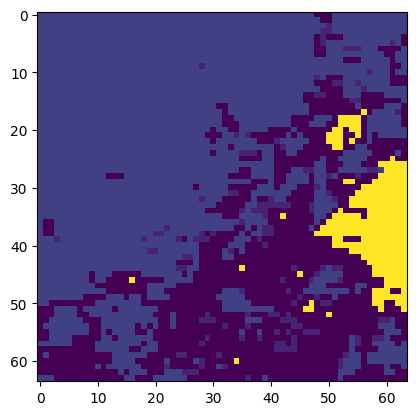

In [14]:
plt.imshow(patch)

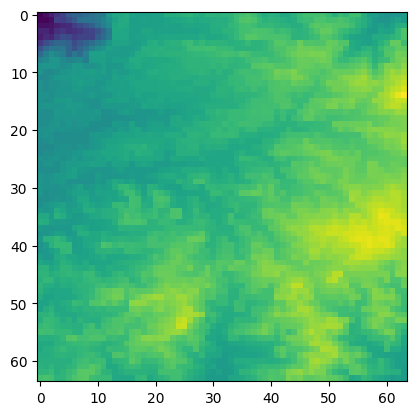

In [15]:
plt.imshow(patch_dem)